### Stroke Prediction Model

Stroke is a leading cause of death and disability worldwide, with risk factors spanning genetics, lifestyle, and environmental factors. Early identification of individuals at risk can lead to the implementation of preventive measures, lifestyle modifications, and monitoring strategies that may significantly reduce the risk of stroke.

The primary objective of this project is to develop a predictive model that can assess the likelihood of an individual experiencing a stroke based on a variety of factors, including demographic information, health data, and lifestyle choices. At a future stage, this model aims to provide healthcare professionals with a tool to identify high-risk individuals for targeted interventions, potentially reducing the incidence of stroke and improving patient outcomes.

#### Dependencies

In [1]:
import shap
import os
import joblib
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
user = os.environ.get("USER")
data_path = f"/Users/{user}/data/stroke_healthcare_dataset.csv"
sys.path.append(f"/Users/{user}/utils/")

In [3]:
model_filename = f"model/stroke_model.pkl"
scoring_metrics = ["precision", "recall", "f1", "roc_auc", "average_precision", "neg_log_loss"]
target = "stroke"

In [4]:
from plot_univariates import plot_univariate

In [5]:
def compute_summary_statistics(df, column):
    data = df[column].dropna()
 

    if len(data) > 0:
        data = np.sort(data)

        percentile_25 = data[int(0.25 * (len(data) - 1))]
        percentile_75 = data[int(0.75 * (len(data) - 1))]

        min_val = data[0]
        max_val = data[-1]
        avg_val = np.mean(data)
        median_val = np.median(data)
    else:
        min_val = np.nan
        max_val = np.nan
        avg_val = np.nan
        median_val = np.nan
        percentile_25 = np.nan
        percentile_75 = np.nan

    formatted_min_val = "{:.4f}".format(min_val)
    formatted_max_val = "{:.4f}".format(max_val)
    formatted_avg_val = "{:.4f}".format(avg_val)
    formatted_median_val = "{:.4f}".format(median_val)
    formatted_percentile_25 = "{:.4f}".format(percentile_25)
    formatted_percentile_75 = "{:.4f}".format(percentile_75)

    return formatted_min_val, formatted_max_val, formatted_avg_val, formatted_median_val, formatted_percentile_25, formatted_percentile_75
 

def plot_top_levels(df1, df2, baseline_features, label1, label2, top_level=5):
    for column_name in baseline_features:
        counts_df1 = df1[column_name].value_counts()
        counts_df2 = df2[column_name].value_counts()
        proportions_df1 = counts_df1 / counts_df1.sum()
        proportions_df2 = counts_df2 / counts_df2.sum()
 

        max_proportion = max(proportions_df1.max(), proportions_df2.max())
        y_axis_cap = max(max_proportion+0.1, 0.25)
        top_proportions_df1 = proportions_df1.nlargest(top_level)
        top_proportions_df2 = proportions_df2.nlargest(top_level)
        x1 = range(len(top_proportions_df1))
        x2 = range(len(top_proportions_df2))
        plt.figure(figsize=(16, 8))
        ax1 = plt.subplot(121)
        ax1.bar(x1, top_proportions_df1.values, label=label1)
        ax1.set_ylabel("Proportion")
        ax1.set_title(f"'{column_name}' Proportions: The Top {top_level} levels in {label1}")
        ax1.set_ylim(0, y_axis_cap)
        ax1.set_xticks(x1)
        ax1.set_xticklabels(top_proportions_df1.index, rotation=45, ha="right")
        ax1.legend()
        ax2 = plt.subplot(122)
        ax2.bar(x2, top_proportions_df2.values, color="orange", label=label2)
        ax2.set_ylabel("Proportion")
        ax2.set_title(f"'{column_name}' Proportions: The Top {top_level} levels in {label2}")
        ax2.set_ylim(0, y_axis_cap)
        ax2.set_xticks(x2)
        ax2.set_xticklabels(top_proportions_df2.index, rotation=45, ha="right")
        ax2.legend()
        for i, val in enumerate(top_proportions_df1.values):
            ax1.text(i, val, f"{val:.2%}", ha="center", va="bottom")
        for i, val in enumerate(top_proportions_df2.values):
            ax2.text(i, val, f"{val:.2%}", ha="center", va="bottom")
          

        plt.tight_layout()
#         plt.savefig(f"{plot_directory}{column_name}.png")
#         plt.close()
    
    # plt.tight_layout()
    plt.show()

### Load Dataset

In [6]:
df = pd.read_csv(data_path, low_memory=False)

In [7]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,drinking_status,at_least_8h_of_sleep,days_of_moderate_exercise_per_week
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Occasional,Yes,6
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,Occasional,No,3
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Regular,Yes,4
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Regular,Yes,6
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Occasional,Yes,2


### EDA

In [8]:
print("Number of observations", df.shape[0])

Number of observations 20000


In [9]:
print("Number of features", df.shape[1])

Number of features 15


In [10]:
print("Distribution of the target variable")
df.stroke.value_counts(2)

Distribution of the target variable


0    0.95345
1    0.04655
Name: stroke, dtype: float64

The distribution of our target variable indicates a highly imbalanced dataset, where the majority class (label '0') comprises about 95.34% and the minority class (label '1') only about 4.66%. Our model might be biased towards the majority class, leading to poor classification performance for the minority class.

#### Feature engineering 

In [11]:
bins = [0, 70, 100, 125, float('inf')]
labels = ['Low', 'Normal', 'Pre-diabetic', 'Diabetic']
df['glucose_category'] = pd.cut(df['avg_glucose_level'], bins=bins, labels=labels, right=False)

df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 60, 120], labels=['Child', 'Young', 'Adult', 'Senior'])

df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

df['age_hypertension'] = df['age'] * df['hypertension']

df['heart_disease_hypertension'] = df['heart_disease'] * df['hypertension']

In [12]:
print("New number of features", df.shape[1])

New number of features 20


In [13]:
df_stroke = df[df["stroke"]==1]
df_not_stroke = df[df["stroke"]==0]

In [14]:
feature = "age"
min1, max1, avg1, median1, p25_1, p75_1 = compute_summary_statistics(df_stroke, feature)
min2, max2, avg2, median2, p25_2, p75_2 = compute_summary_statistics(df_not_stroke, feature)
 

statistics_data = {
    "Metric": ["Minimum", "25th Percentile", "Median", "Average", "75th Percentile", "Maximum"],
    "Stroke": [min1, p25_1, median1, avg1, p75_1, max1],
    "Not Stroke": [min2, p25_2, median2, avg2, p75_2, max2]

}


print(f"Summary Statistics for {feature}:\n")
summary_df = pd.DataFrame(statistics_data)
summary_df.set_index("Metric", inplace=True)
summary_df

Summary Statistics for age:



,Stroke,Not Stroke
Metric,,
Minimum,1.3200,0.0800
25th Percentile,59.0000,24.0000
Median,70.0000,43.0000
Average,67.5499,41.8200
75th Percentile,78.0000,59.0000
Maximum,82.0000,82.0000


At first glance, we can see that the stroke population tends to be older compared to individuals with no stroke. This is on par with expectation.

Summary Statistics for avg_glucose_level:



,Stroke,Not Stroke
Metric,,
Minimum,56.1100,55.1200
25th Percentile,78.9200,77.0100
Median,105.9200,91.6300
Average,131.2960,104.6464
75th Percentile,194.3700,112.9800
Maximum,271.7400,267.7600


Summary Statistics for bmi:



,Stroke,Not Stroke
Metric,,
Minimum,16.9000,10.3000
25th Percentile,26.6000,23.5000
Median,29.6000,27.9500
Average,30.6279,28.8117
75th Percentile,34.1000,33.0000
Maximum,56.6000,97.6000


Summary Statistics for days_of_moderate_exercise_per_week:



,Stroke,Not Stroke
Metric,,
Minimum,0.0000,0.0000
25th Percentile,1.0000,1.0000
Median,2.0000,2.0000
Average,2.3383,2.3399
75th Percentile,3.0000,3.0000
Maximum,7.0000,7.0000


#### Plotting

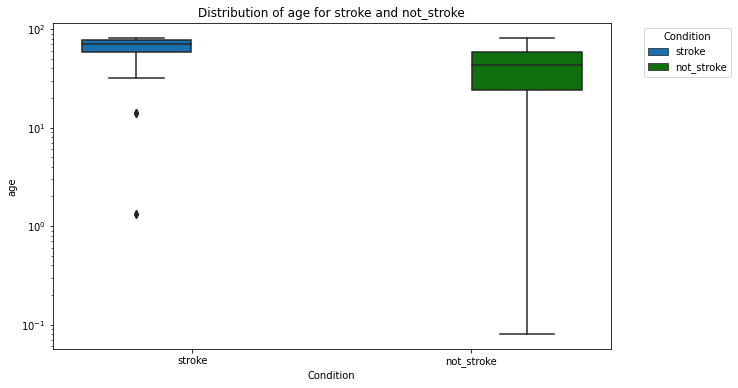

In [18]:
feature = "age"
dataframes = [df_stroke, df_not_stroke]
combined_df = pd.concat(dataframes, keys=["stroke", "not_stroke"]
                       ).reset_index(level=0).rename(columns={'level_0': 'Condition'})

colors = {"stroke": "#0074C8", "not_stroke": "#008000"}

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='Condition', hue='Condition', y=feature,
            palette=colors)

plt.yscale("log")
plt.title(f"Distribution of {feature} for stroke and not_stroke")
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.savefig(f"{plot_directory}{feature}.png")
plt.show()


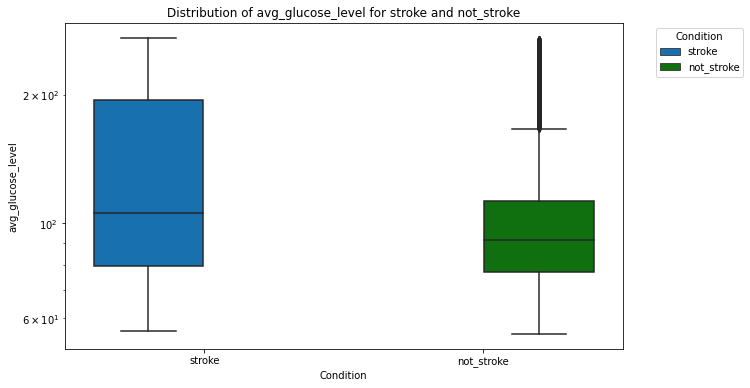

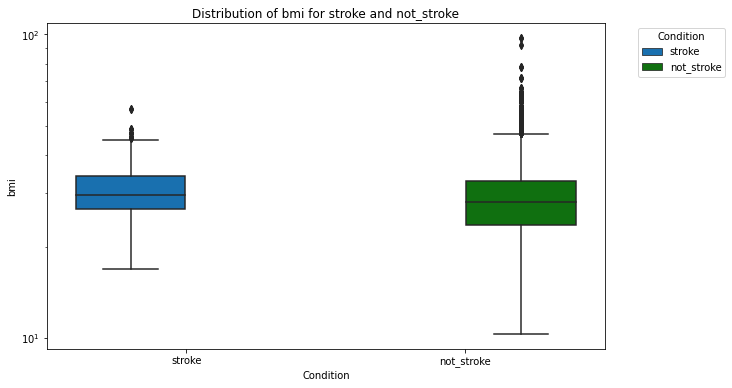

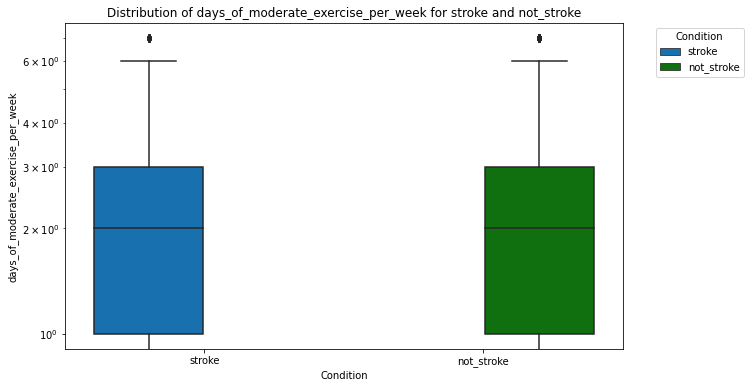

In [22]:
# Features of interest for this plot
variables_list = list(df.columns.drop('id'))

for variable in ["age", "bmi", "avg_glucose_level", "days_of_moderate_exercise_per_week"]:
    if variable in variables_list:
        variables_list.remove(variable)

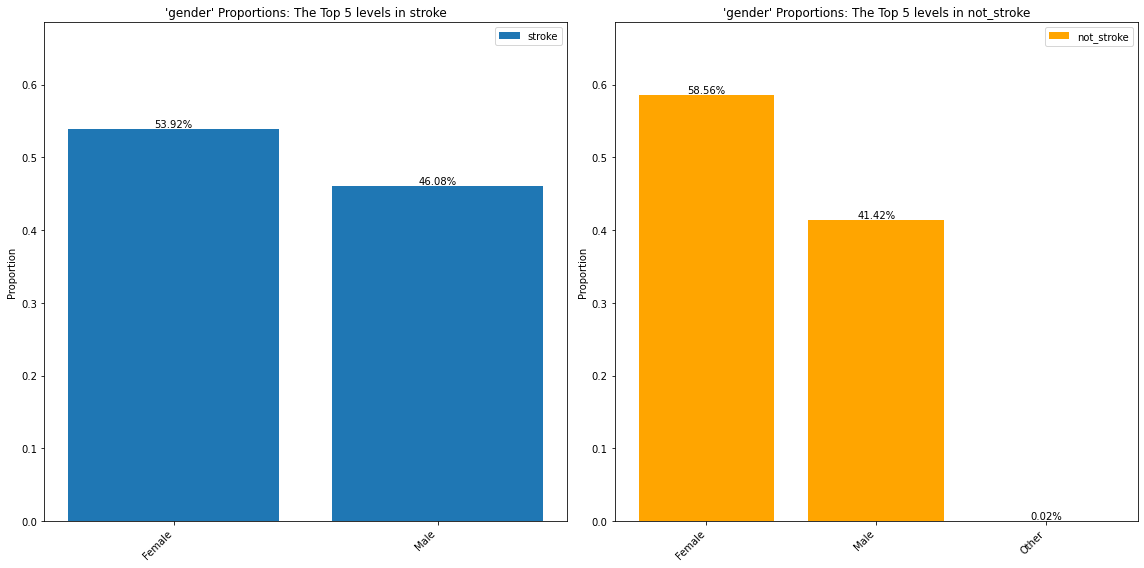

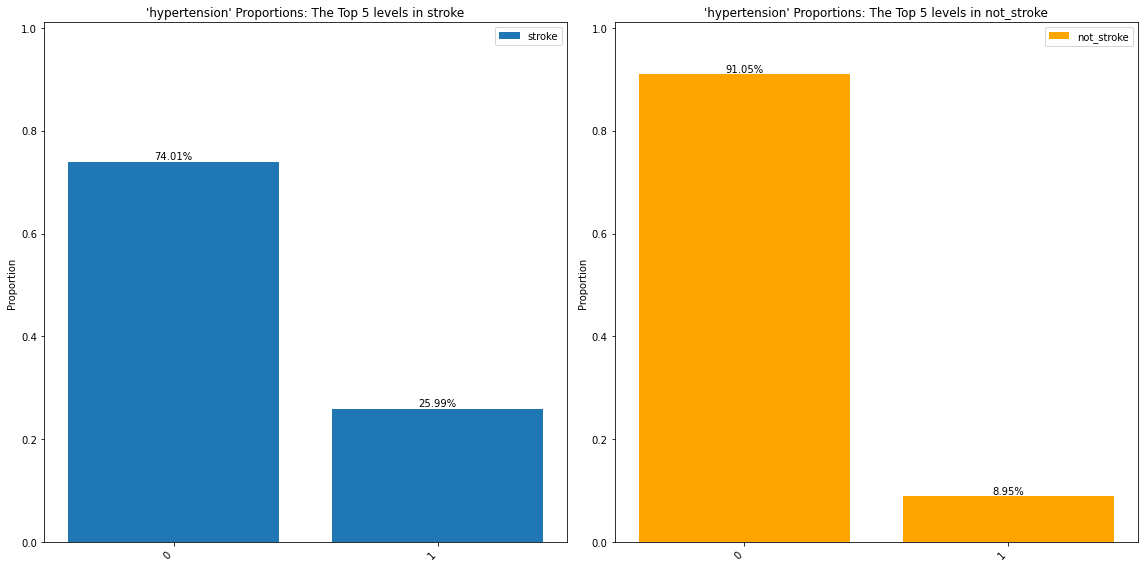

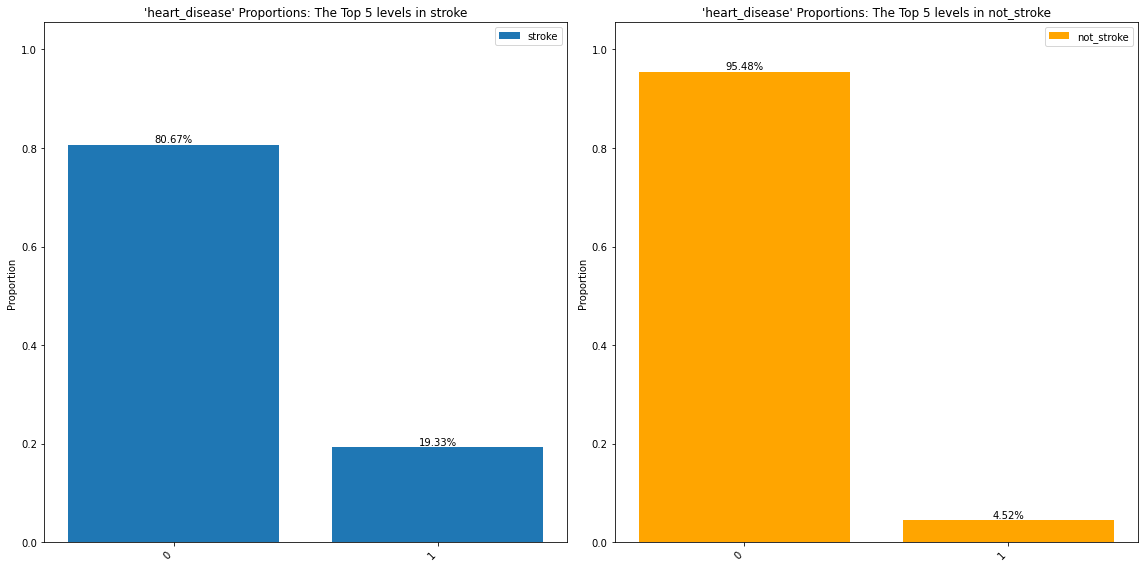

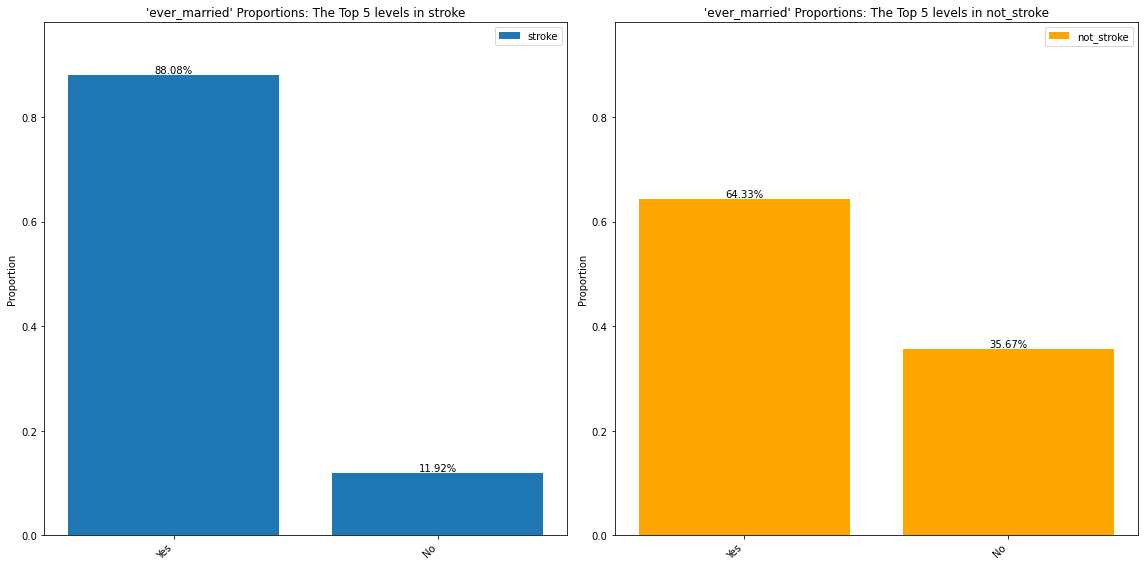

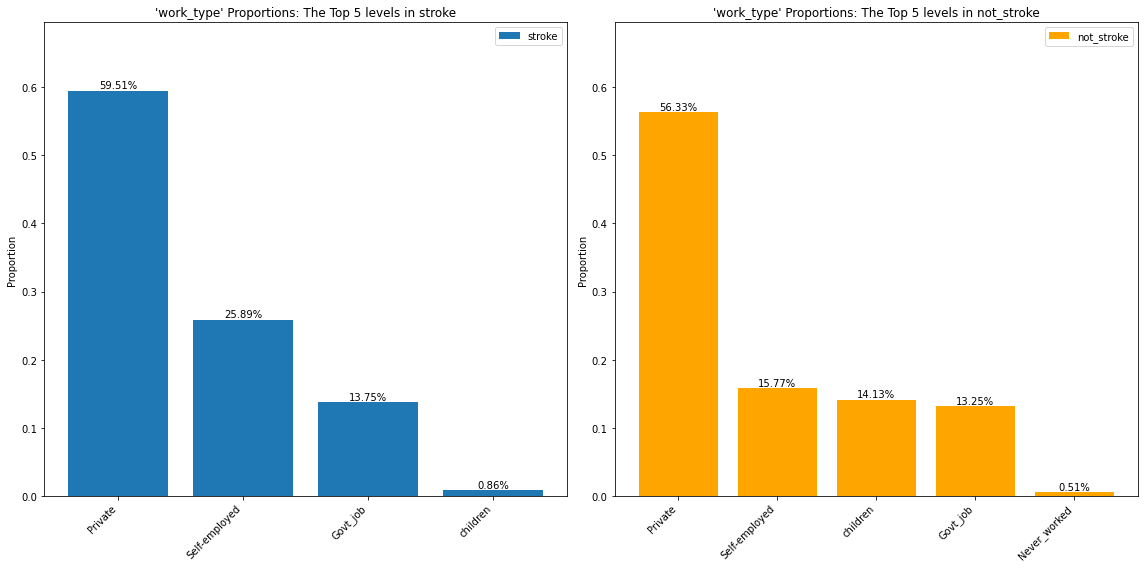

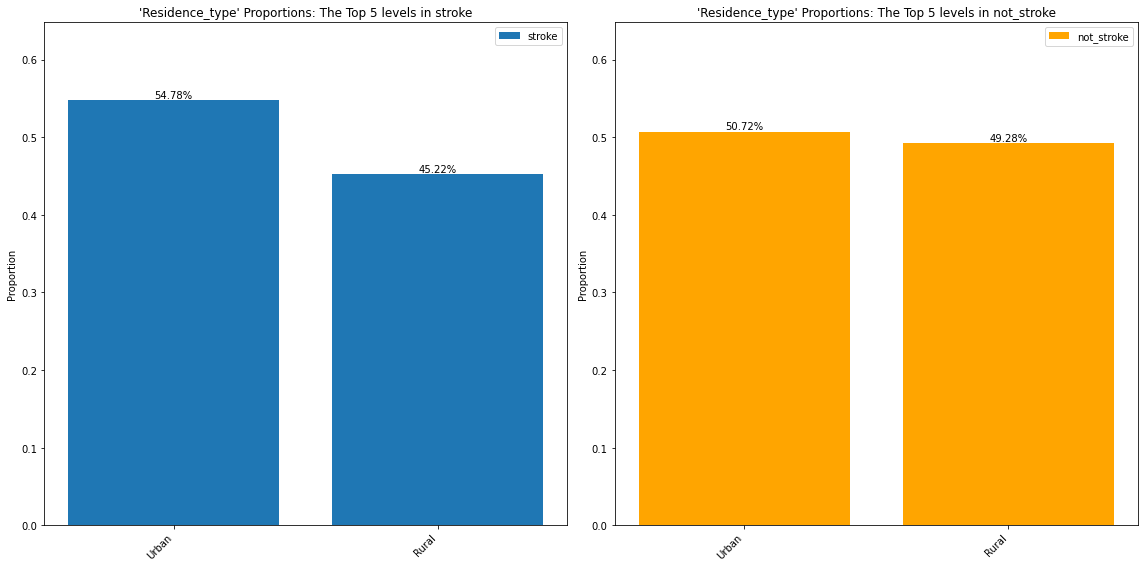

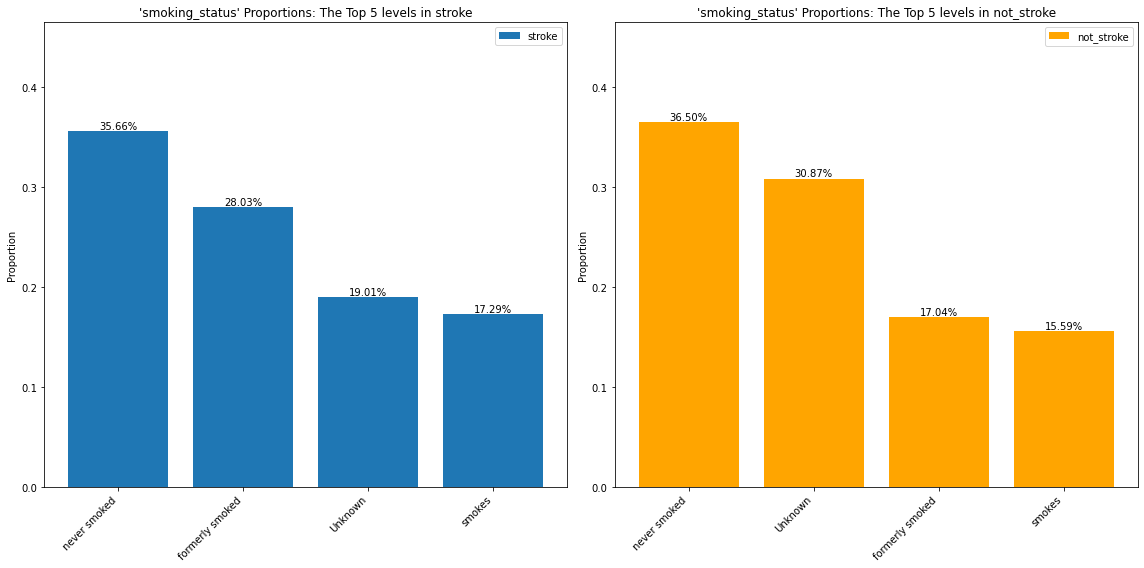

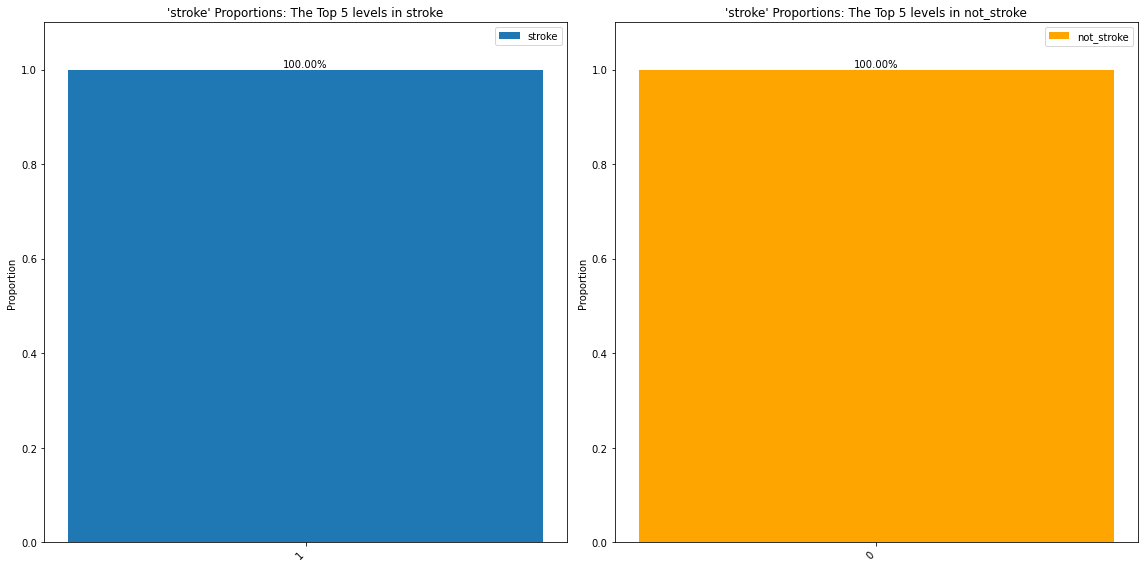

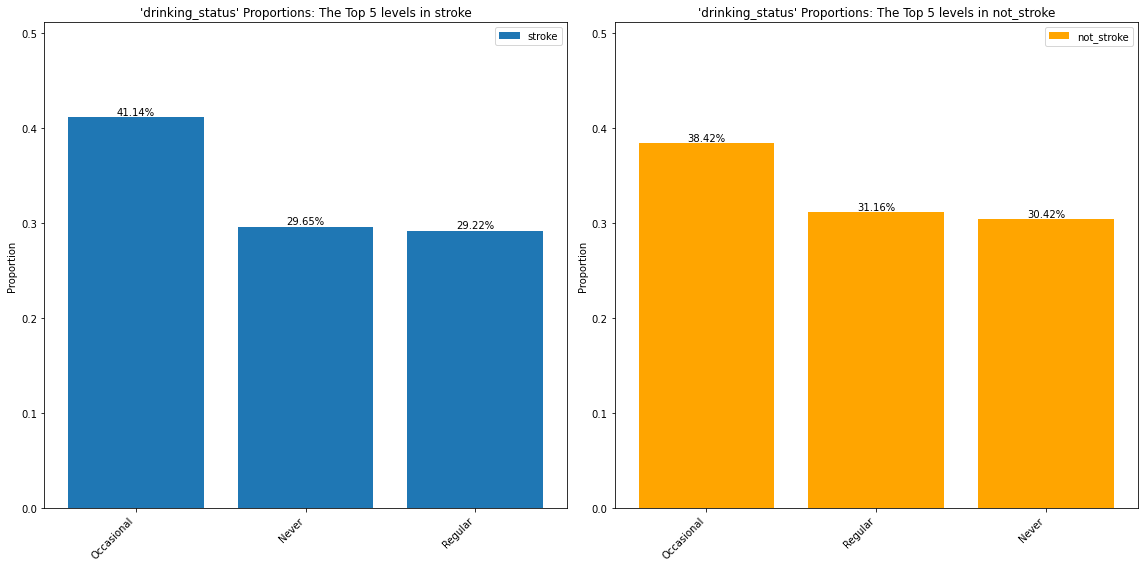

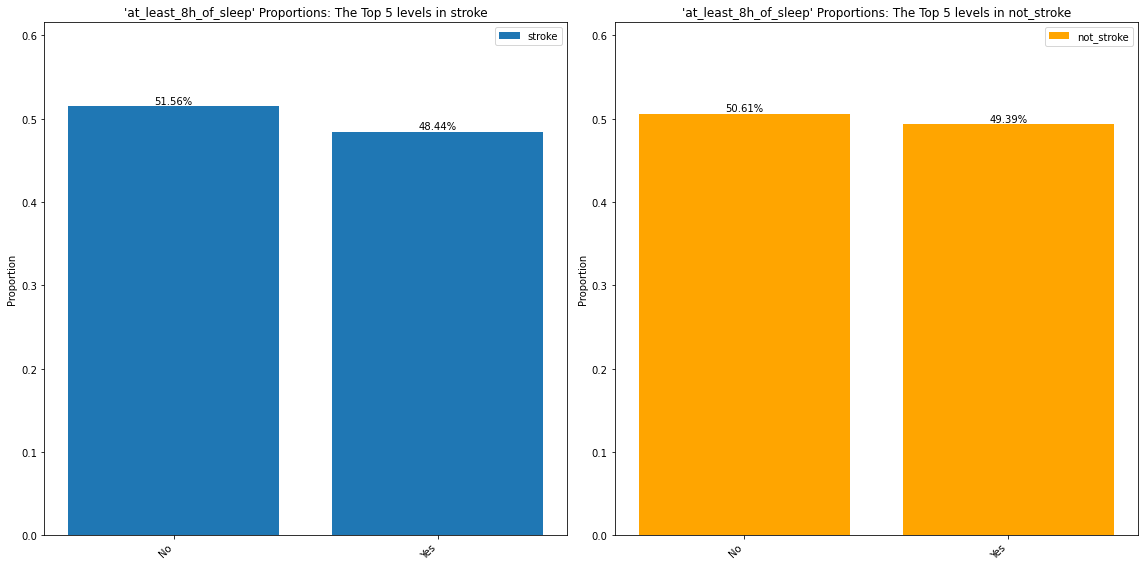

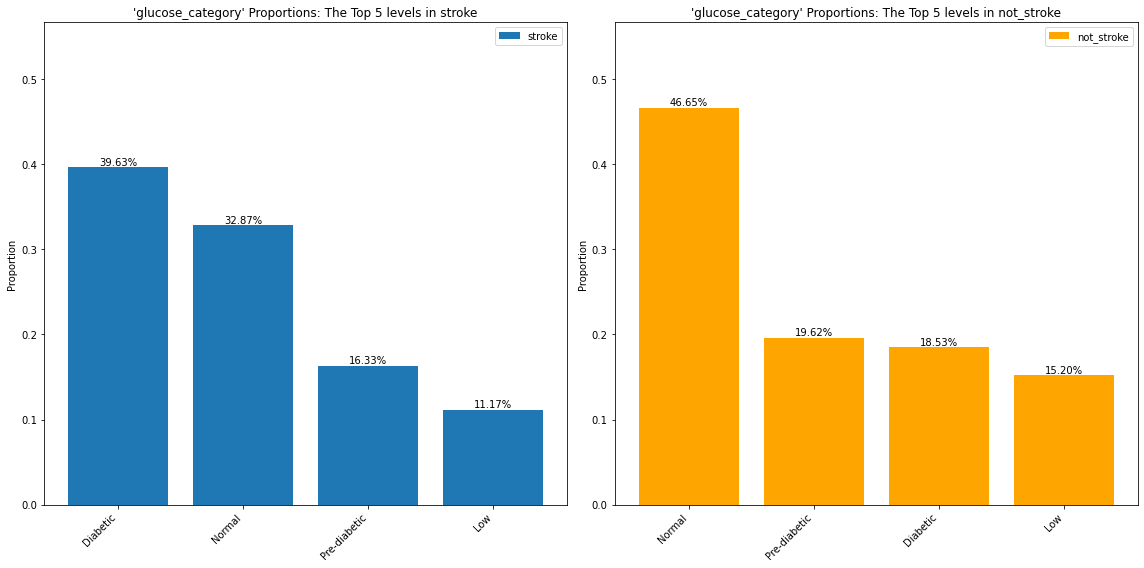

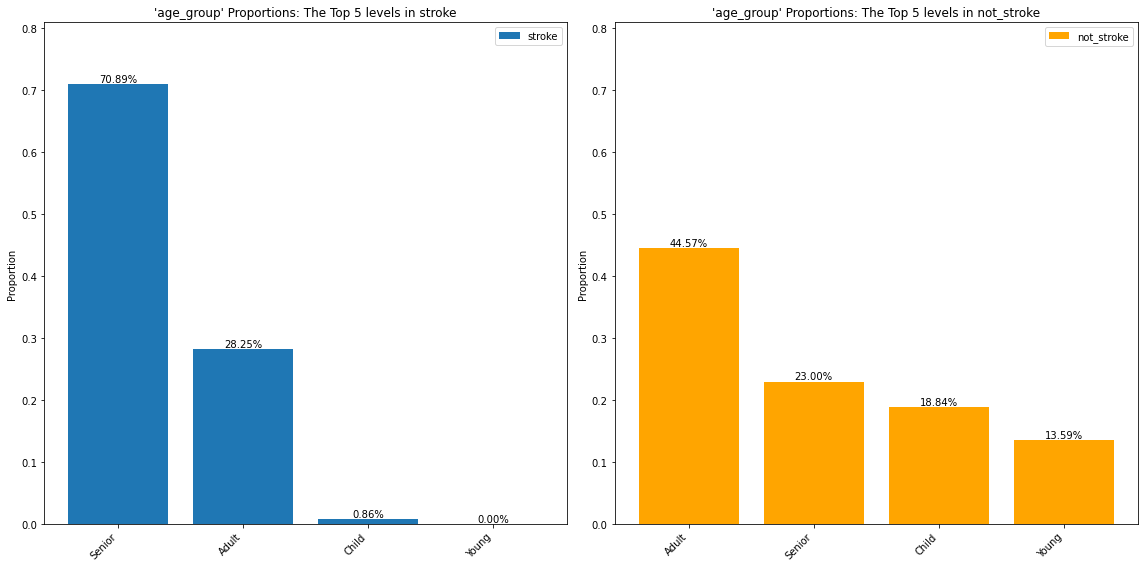

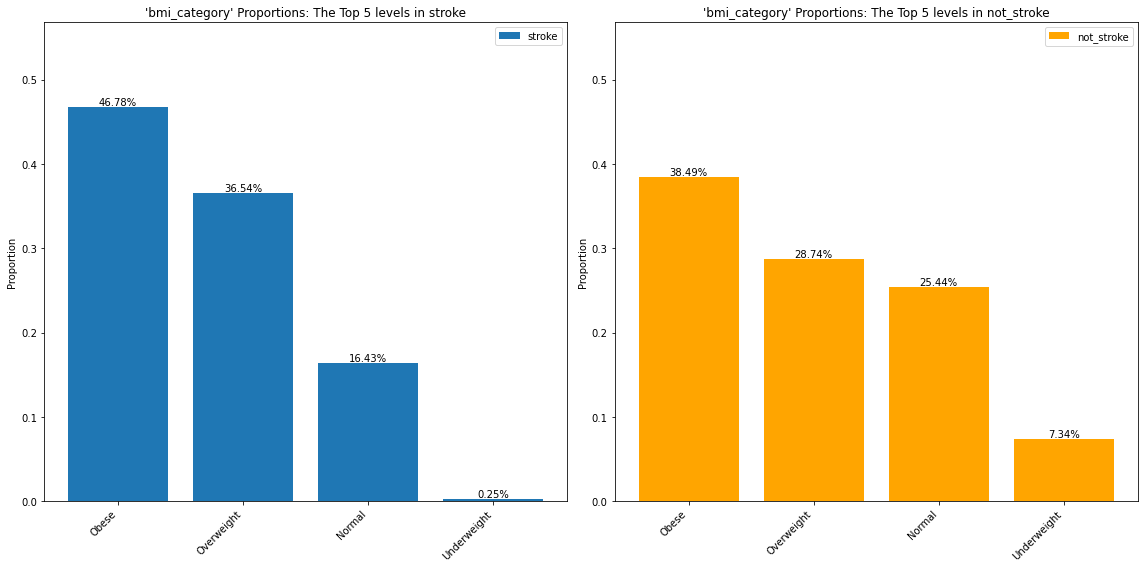

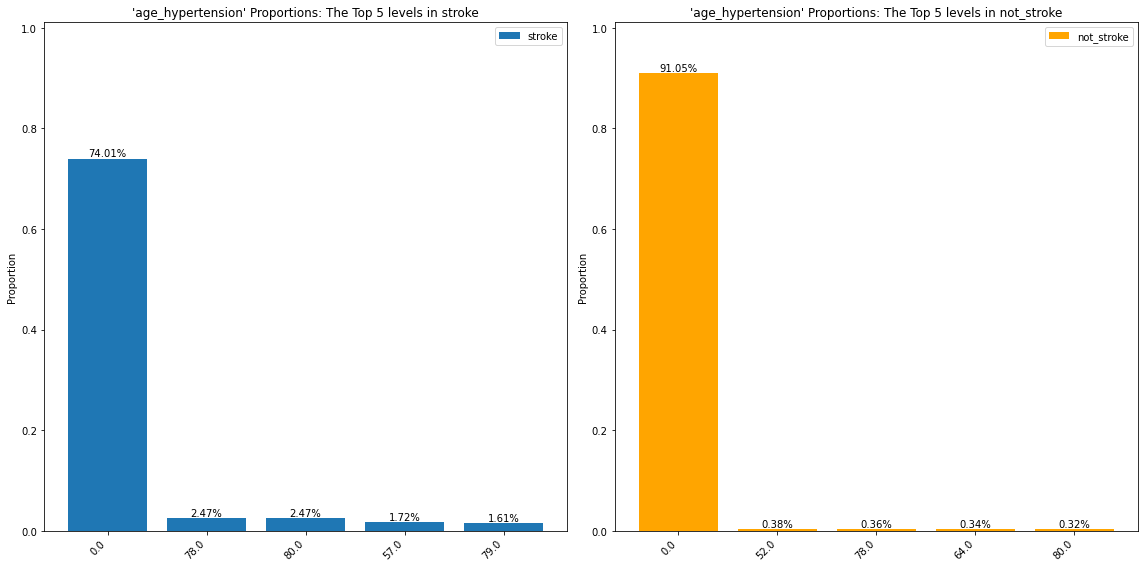

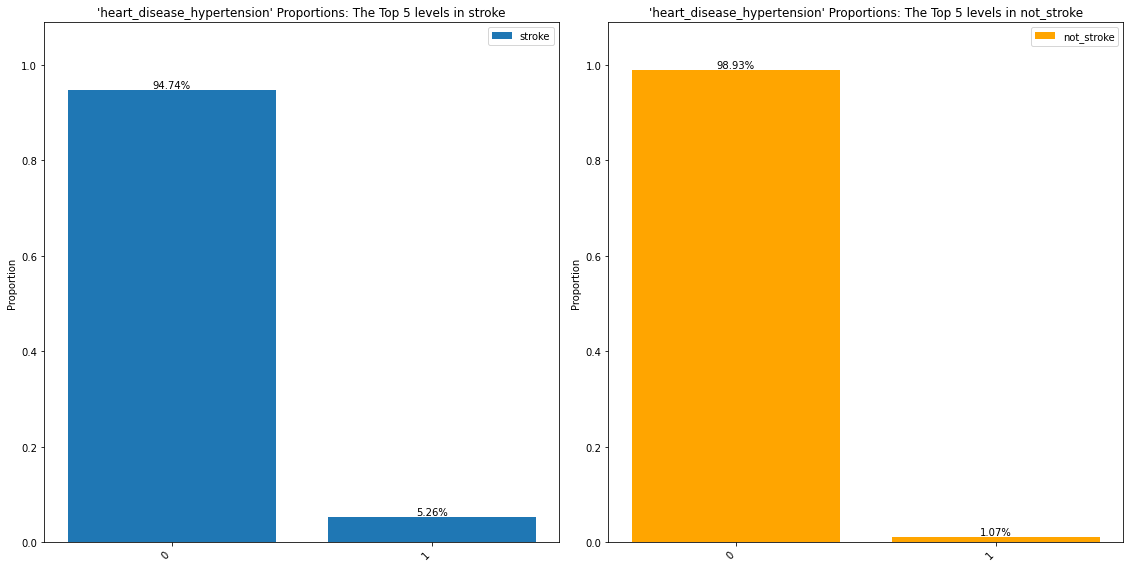

In [23]:
plot_top_levels(df_stroke, df_not_stroke, variables_list, "stroke", "not_stroke")

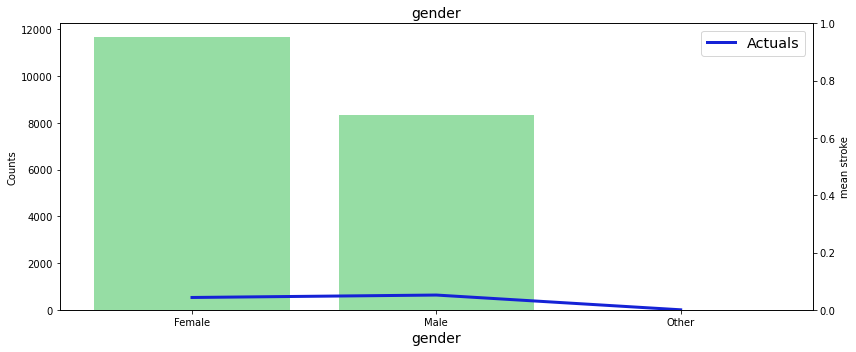

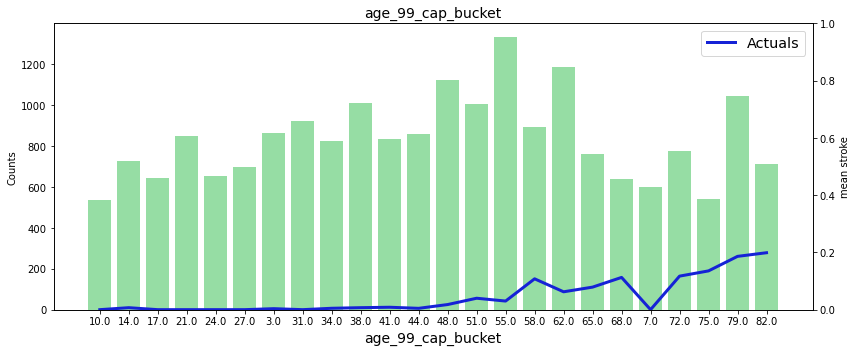

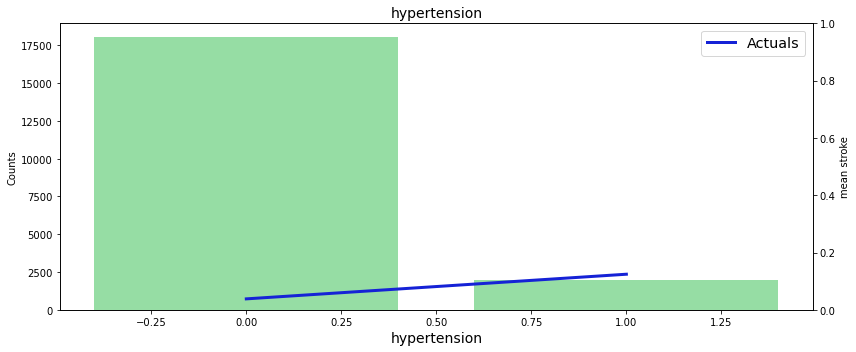

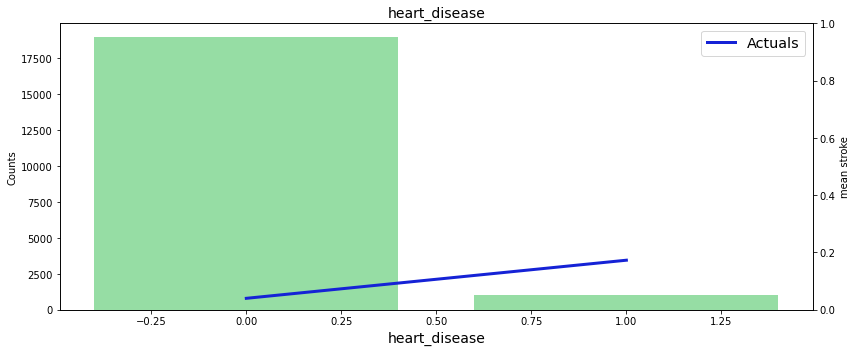

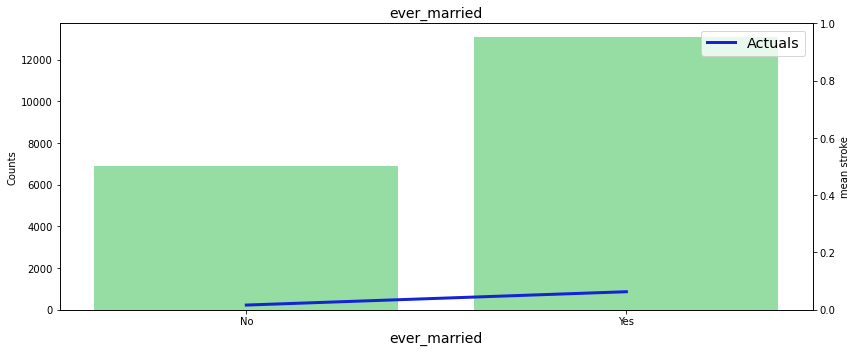

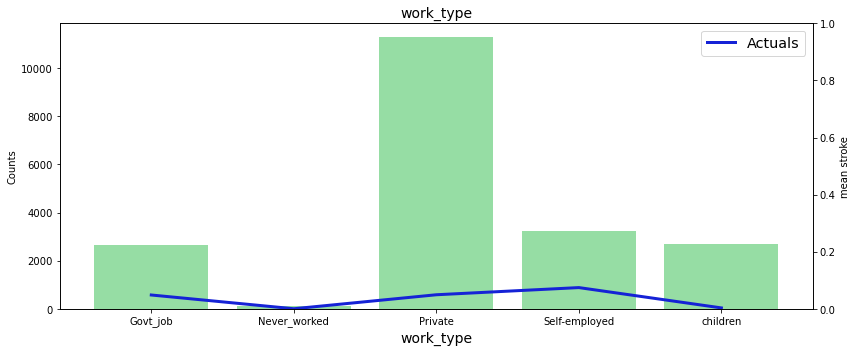

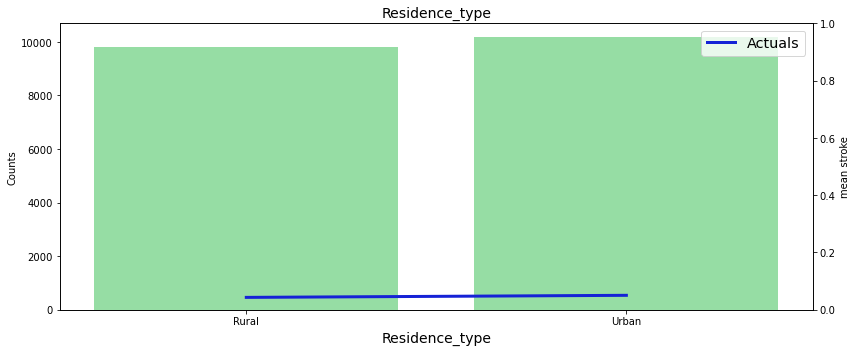

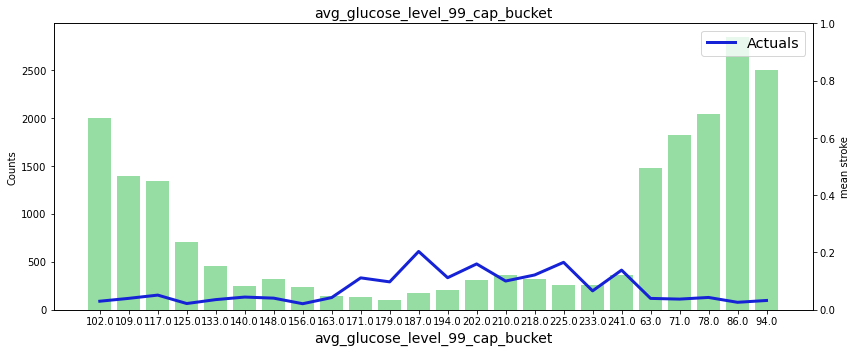

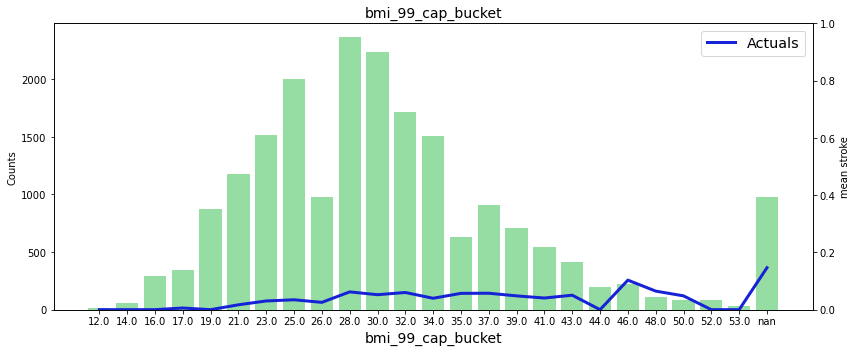

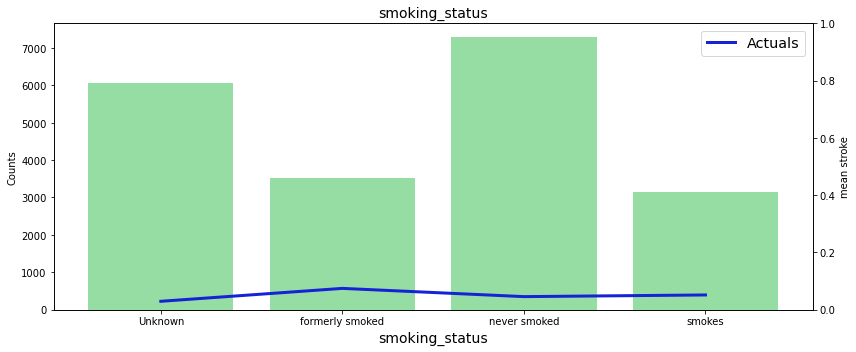

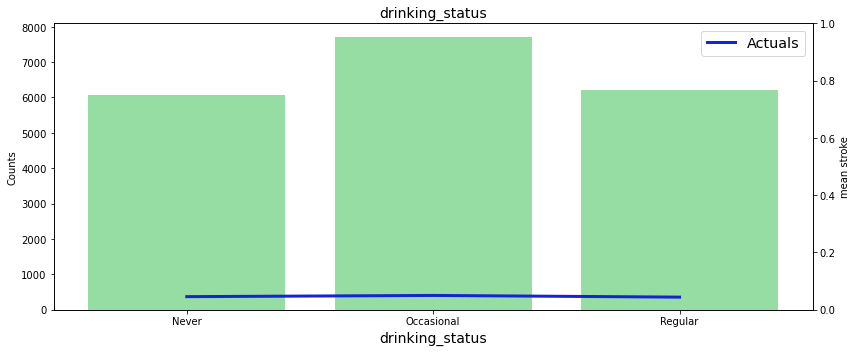

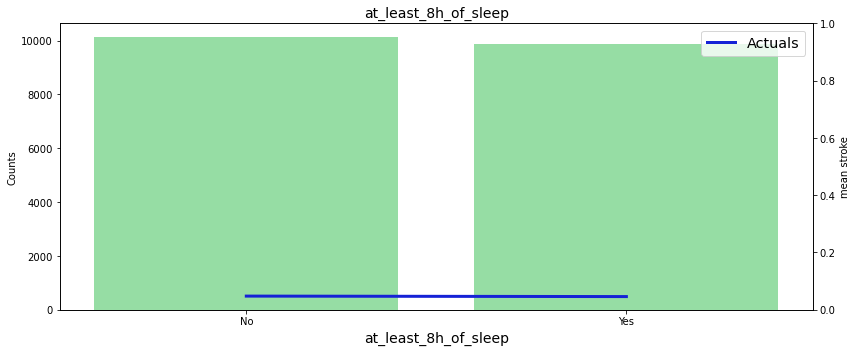

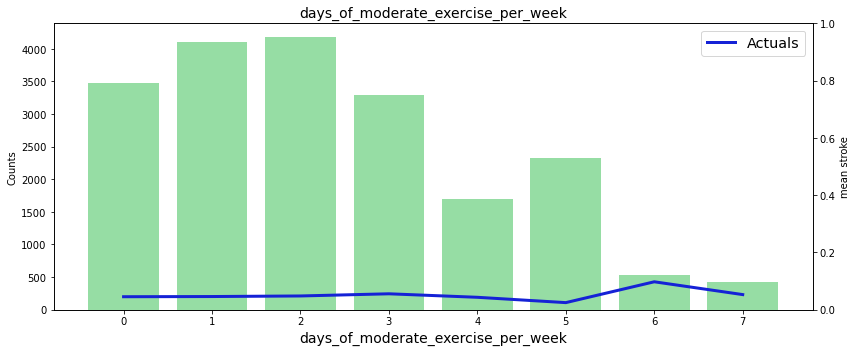

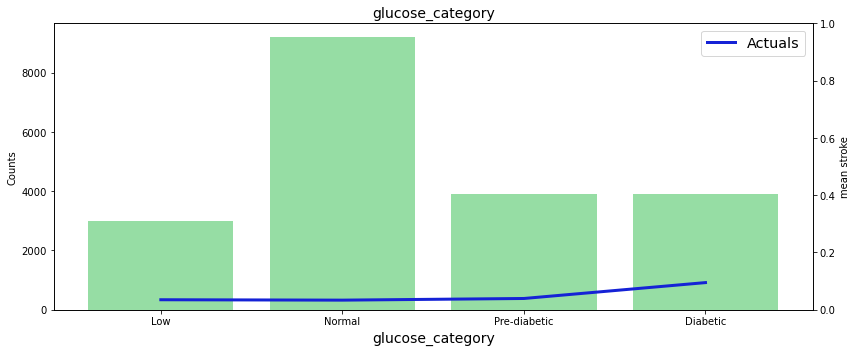

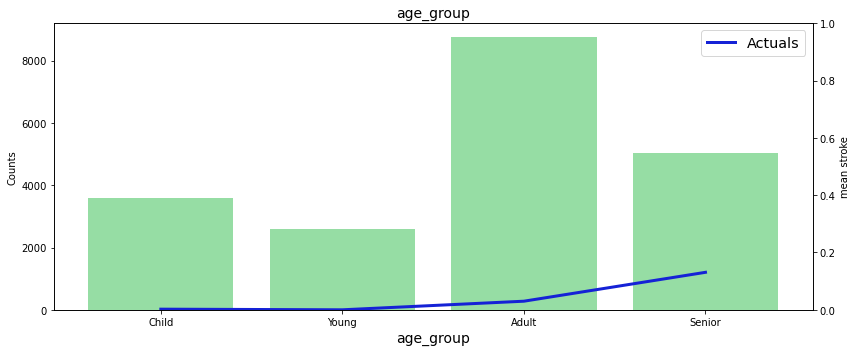

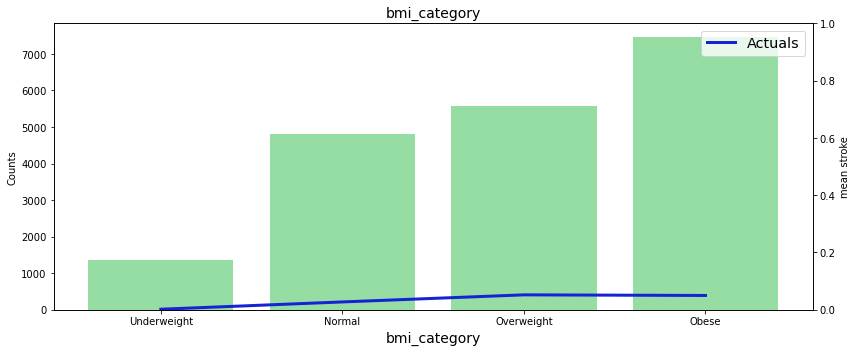

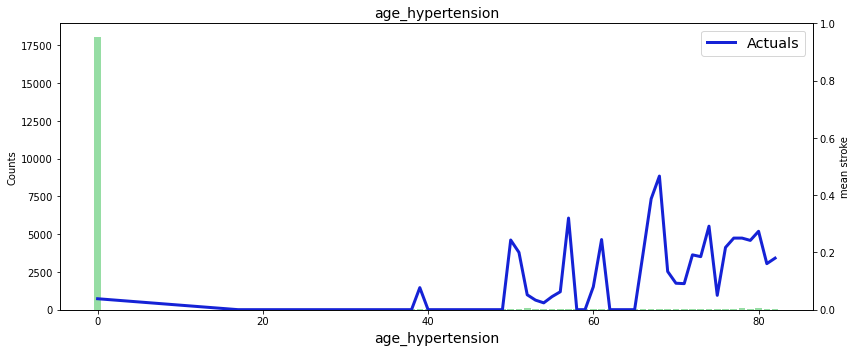

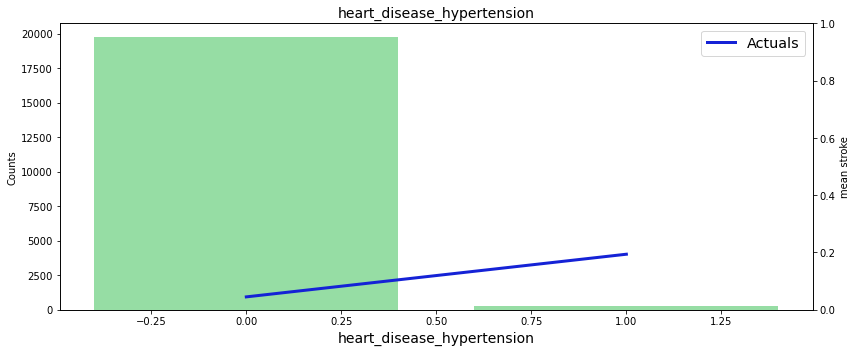

In [24]:
df_plot = df.copy()
variables_list = list(df_plot.columns.drop(['id', 'stroke']))
plot_univariate(df_plot, variables_list, target, savename=None, cap_at_99th=True, show=True)

### Modeling

In [25]:
categorical_features = list(df.columns.drop(['id', 'age', 'avg_glucose_level', 'bmi', 'stroke']))

In [26]:
df_encoded = pd.get_dummies(df, columns=categorical_features)

In [27]:
X = df_encoded.drop(['id', 'stroke'], axis=1)
y = df_encoded['stroke'] 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

#### Model

In [29]:
# This is to balance the positive and negative classes.
# Hoping to improve performance by adjusting the algorithm's focus on minority classes.

scale_pos_weight = len([label for label in y_train if label == 0]) / len([label for label in y_train if label == 1])

In [30]:
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=1000,
    max_depth=3,
    max_delta_step=2,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric=['aucpr', 'logloss'],
    nthread=50,
    random_state=50,
    early_stopping_rounds=25
)

In [ ]:
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring_metrics)

In [32]:
for metric in scoring_metrics:
    pretty_metric_name = metric.replace('_', ' ').capitalize() if metric != 'neg_log_loss' else 'Log Loss'
#     print(f"{pretty_metric_name} Scores: {cv_results['test_' + metric]}")
    print(f"Cross Validation {pretty_metric_name}: {cv_results['test_' + metric].mean()}\n")


Cross Validation Precision: 0.9322936376230583

Cross Validation Recall: 0.9073980481003835

Cross Validation F1: 0.919350704337055

Cross Validation Roc auc: 0.9812945550809751

Cross Validation Average precision: 0.9385158731560738

Cross Validation Log Loss: -0.038879757915192166



In [ ]:
# save the model
# joblib.dump(model, model_filename)

#### Performance Takeaway

The model demonstrates exceptional accuracy in predicting stroke cases, with a recall of 91.1%, meaning it successfully identifies 91.1% of all actual stroke events. Its F1 score of 0.849 indicates a strong balance between precision and recall, ensuring it effectively identifies stroke cases while minimizing false alarms. The ROC AUC score of 0.982 highlights its outstanding ability to distinguish between patients with and without stroke. Additionally, an average precision score of 0.925 confirms its high precision across different levels of recall, crucial for medical diagnostics. The Log Loss of 0.058 indicates the model's predicted probabilities are highly accurate. Overall, this model is highly effective and reliable in predicting stroke cases.

#### Feature importance

In [ ]:
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

In [34]:
feature_importances = model.feature_importances_
importance_series = pd.Series(data=feature_importances, index=X_train.columns)

importance_series_sorted = importance_series.sort_values(ascending=False)

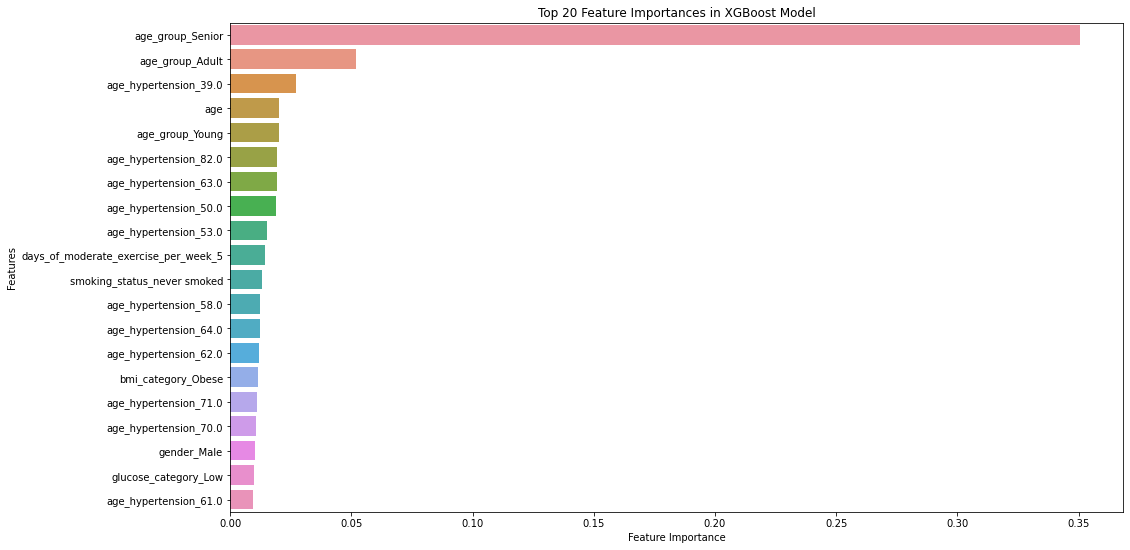

In [35]:
top_20_features = importance_series_sorted.head(20)

plt.figure(figsize=(16, 9))
sns.barplot(x=top_20_features, y=top_20_features.index)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances in XGBoost Model')
plt.show()

#### SHAP Plot

100%|===================| 15968/16000 [03:05<00:00]        

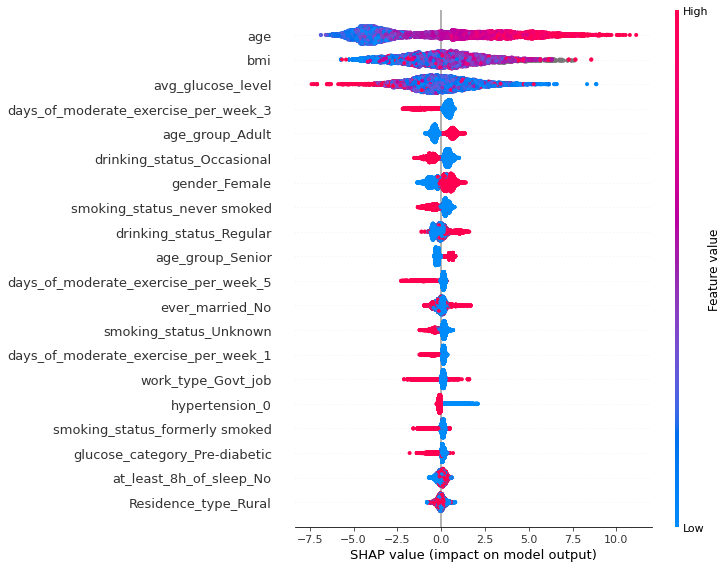

In [36]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

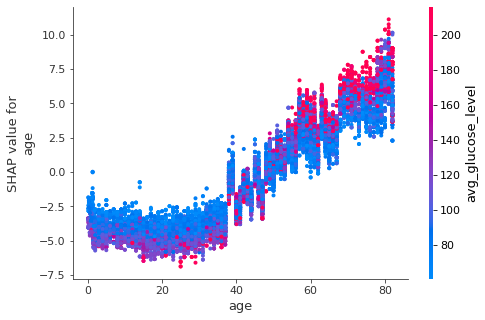

In [37]:
shap_values_array = shap_values.values
shap.dependence_plot('age', shap_values_array, X_train)

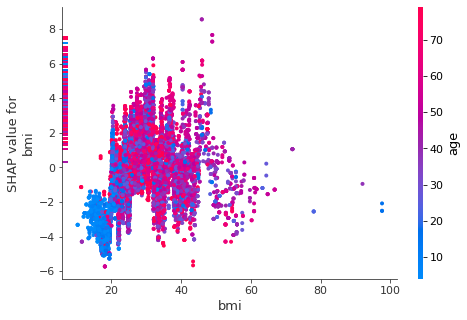

In [38]:
shap.dependence_plot('bmi', shap_values_array, X_train)

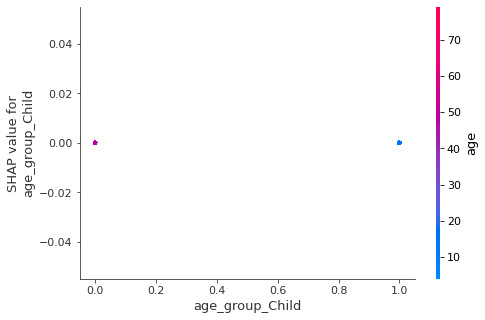

In [39]:
shap.dependence_plot('age_group_Child', shap_values_array, X_train)

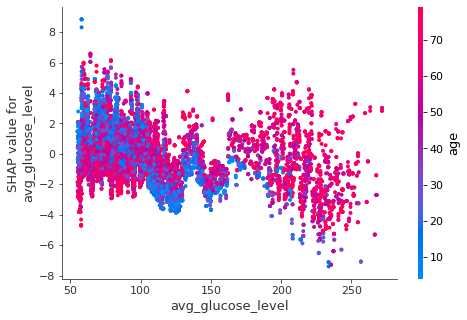

In [41]:
shap.dependence_plot('avg_glucose_level', shap_values_array, X_train)